In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import load_model
model = load_model("health_alert_model.h5")


# Load a few rows (simulate live input)
new_data = pd.read_csv('health_monitoring.csv').tail(10)  # Simulated latest entries

# Split systolic and diastolic if format is '120/80'
bp_split = new_data['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)/(?P<Diastolic>\d+)')

# Where BP is in 'mmHg', extract number only
bp_single = new_data['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)\s*mmHg')
 
# Fill in systolic from either format
new_data['Systolic BP'] = pd.to_numeric(bp_split['Systolic'].fillna(bp_single['Systolic']), errors='coerce')

# Fill in diastolic from split format or 0 if missing
new_data['Diastolic BP'] = pd.to_numeric(bp_split['Diastolic'].fillna(0), errors='coerce')

# Define features for scaling
features = ['Heart Rate', 'Systolic BP', 'Diastolic BP', 'Glucose Levels', 'Oxygen Saturation (SpO₂%)']

# Scale features
scaler = MinMaxScaler()
X_new_scaled = scaler.fit_transform(new_data[features])
X_new_seq = []

# Create time windows (assuming 10-timestep window)
for i in range(len(X_new_scaled) - 9):
    X_new_seq.append(X_new_scaled[i:i+10])

X_new_seq = np.array(X_new_seq)

# Predict
predictions = model.predict(X_new_seq)
alerts = (predictions > 0.5).astype(int)
print("Predicted Alert Flags:", alerts.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted Alert Flags: [1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


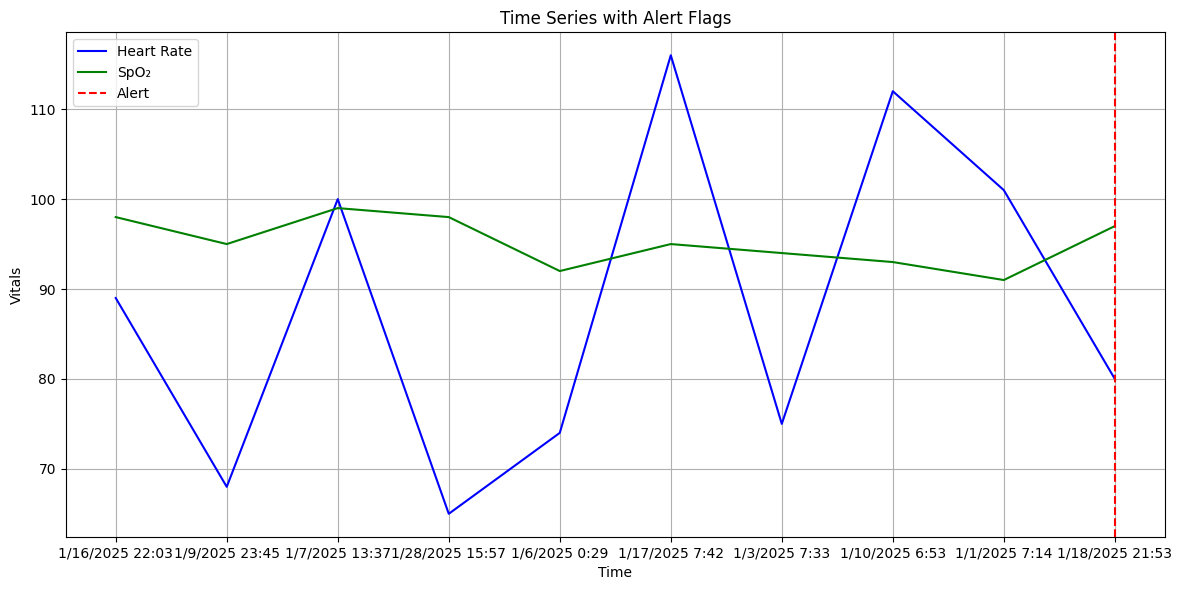

⚠️ Real Alert Triggered!
⚠️ Real Alert Triggered!
SMS sent: SM67da1bce1104c86e0eec91f323c35775


In [5]:
import matplotlib.pyplot as plt

# Load full data
full_data = pd.read_csv('health_monitoring.csv')

# Extract last 10 rows (used in prediction)
new_data = full_data.tail(10).reset_index(drop=True)

# Create timestamp column if missing
if 'Timestamp' not in new_data.columns:
    new_data['Timestamp'] = pd.date_range(end=pd.Timestamp.now(), periods=10, freq='T')

# Preprocess Blood Pressure
bp_split = new_data['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)/(?P<Diastolic>\d+)')
bp_single = new_data['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)\s*mmHg')
new_data['Systolic BP'] = pd.to_numeric(bp_split['Systolic'].fillna(bp_single['Systolic']), errors='coerce')
new_data['Diastolic BP'] = pd.to_numeric(bp_split['Diastolic'].fillna(0), errors='coerce')

# Normalize
features = ['Heart Rate', 'Systolic BP', 'Diastolic BP', 'Glucose Levels', 'Oxygen Saturation (SpO₂%)']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(new_data[features])

# Sequence for model
X_seq = np.array([X_scaled])

# Predict
predictions = model.predict(X_seq)
alerts = (predictions > 0.5).astype(int)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(new_data['Timestamp'], new_data['Heart Rate'], label='Heart Rate', color='blue')
plt.plot(new_data['Timestamp'], new_data['Oxygen Saturation (SpO₂%)'], label='SpO₂', color='green')

if alerts[0][0] == 1:
    plt.axvline(x=new_data['Timestamp'].iloc[-1], color='red', linestyle='--', label='Alert')

plt.title("Time Series with Alert Flags")
plt.xlabel("Time")
plt.ylabel("Vitals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("⚠️ Real Alert Triggered!" if alerts[0][0] == 1 else "✅ All Clear")



#twillow alert/////////////////

from twilio.rest import Client

def send_alert_sms(to_number, heart_rate, spo2):
    account_sid = 'ACb1a03aeb9b81fadc8f8931810197d384'
    auth_token = 'e697f4f68e85195d19cbe912e3e32229'
    client = Client(account_sid, auth_token)

    message_body = f"⚠️ Health Alert!\nHeart Rate: {heart_rate} bpm\nSpO₂: {spo2}%"

    message = client.messages.create(
        body=message_body,
        from_='+18653916889',
        to=to_number
    )

    print(f"SMS sent: {message.sid}")

alert_triggered = alerts[0][0] == 1

if alert_triggered:
    print("⚠️ Real Alert Triggered!")
    send_alert_sms('+918270120006', new_data['Heart Rate'].iloc[-1], new_data['Oxygen Saturation (SpO₂%)'].iloc[-1])

else:
    print("✅ All Clear")



In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

model = load_model("health_alert_model.h5")

# Load full data
df = pd.read_csv("health_monitoring.csv")

# Process Blood Pressure (as before)
bp_split = df['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)/(?P<Diastolic>\d+)')
bp_single = df['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)\s*mmHg')

df['Systolic BP'] = pd.to_numeric(bp_split['Systolic'].fillna(bp_single['Systolic']), errors='coerce')
df['Diastolic BP'] = pd.to_numeric(bp_split['Diastolic'].fillna(0), errors='coerce')

# Features to use
features = ['Heart Rate', 'Systolic BP', 'Diastolic BP', 'Glucose Levels', 'Oxygen Saturation (SpO₂%)']
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

# Simulate real-time windows of 10 timesteps
for i in range(len(df_scaled) - 9):
    X_seq = np.array([df_scaled[i:i+10]])
    prediction = model.predict(X_seq)
    alert = (prediction > 0.7).astype(int)[0][0]
    
    # Extract latest row info
    latest = df.iloc[i+9]
    print(f"\n--- Timestamp: {latest['Timestamp']} ---")
    print(f"Heart Rate: {latest['Heart Rate']} bpm | SpO₂: {latest['Oxygen Saturation (SpO₂%)']}%")
    print("⚠️ ALERT!" if alert else "✅ All Clear")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

--- Timestamp: 1/23/2025 16:54 ---
Heart Rate: 88 bpm | SpO₂: 94%
⚠️ ALERT!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

--- Timestamp: 1/29/2025 17:52 ---
Heart Rate: 61 bpm | SpO₂: 98%
⚠️ ALERT!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

--- Timestamp: 1/23/2025 15:03 ---
Heart Rate: 89 bpm | SpO₂: 91%
⚠️ ALERT!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

--- Timestamp: 1/11/2025 10:32 ---
Heart Rate: 105 bpm | SpO₂: 93%
⚠️ ALERT!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

--- Timestamp: 1/14/2025 19:53 ---
Heart Rate: 69 bpm | SpO₂: 95%
⚠️ ALERT!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

--- Timestamp: 1/13/2025 10:53 ---
Heart Rate: 63 bpm | SpO₂: 91%
⚠️ ALERT!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

--- Timestamp: 1/14/2025 5:57 ---
Heart Rate: 63 bpm | SpO₂: 99%
⚠️ ALERT!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

--- Timestamp: 1/24/2025 20:01 ---
Heart Rate: 74 bpm | SpO₂: 90%
⚠️ ALERT!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

--- Timestamp: 1/17/2025 7:26 ---
Heart 

KeyboardInterrupt: 

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("health_alert_model.h5")

# Load dataset
df = pd.read_csv("health_monitoring.csv")

# Process Blood Pressure
bp_split = df['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)/(?P<Diastolic>\d+)')
bp_single = df['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)\s*mmHg')

df['Systolic BP'] = pd.to_numeric(bp_split['Systolic'].fillna(bp_single['Systolic']), errors='coerce')
df['Diastolic BP'] = pd.to_numeric(bp_split['Diastolic'].fillna(0), errors='coerce')

# Select relevant features
features = ['Heart Rate', 'Systolic BP', 'Diastolic BP', 'Glucose Levels', 'Oxygen Saturation (SpO₂%)']
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

# Compute all prediction scores
predictions = [model.predict(np.array([df_scaled[i:i+10]]), verbose=0)[0][0] for i in range(len(df_scaled) - 9)]

# Calculate dynamic threshold using the 90th percentile
threshold = np.percentile(predictions, 90)

# Simulate real-time prediction using dynamic threshold
for i, prediction in enumerate(predictions):
    alert = prediction > threshold
    latest = df.iloc[i+9]
    print(f"\n--- Timestamp: {latest['Timestamp']} ---")
    print(f"Heart Rate: {latest['Heart Rate']} bpm | SpO₂: {latest['Oxygen Saturation (SpO₂%)']}%")
    print(f"Prediction Score: {prediction:.4f}")
    print("⚠️ ALERT!" if alert else "✅ All Clear")



--- Timestamp: 1/23/2025 16:54 ---
Heart Rate: 88 bpm | SpO₂: 94%
Prediction Score: 0.7353
✅ All Clear

--- Timestamp: 1/29/2025 17:52 ---
Heart Rate: 61 bpm | SpO₂: 98%
Prediction Score: 0.7424
✅ All Clear

--- Timestamp: 1/23/2025 15:03 ---
Heart Rate: 89 bpm | SpO₂: 91%
Prediction Score: 0.7305
✅ All Clear

--- Timestamp: 1/11/2025 10:32 ---
Heart Rate: 105 bpm | SpO₂: 93%
Prediction Score: 0.7264
✅ All Clear

--- Timestamp: 1/14/2025 19:53 ---
Heart Rate: 69 bpm | SpO₂: 95%
Prediction Score: 0.7375
✅ All Clear

--- Timestamp: 1/13/2025 10:53 ---
Heart Rate: 63 bpm | SpO₂: 91%
Prediction Score: 0.7365
✅ All Clear

--- Timestamp: 1/14/2025 5:57 ---
Heart Rate: 63 bpm | SpO₂: 99%
Prediction Score: 0.7435
⚠️ ALERT!

--- Timestamp: 1/24/2025 20:01 ---
Heart Rate: 74 bpm | SpO₂: 90%
Prediction Score: 0.7279
✅ All Clear

--- Timestamp: 1/17/2025 7:26 ---
Heart Rate: 64 bpm | SpO₂: 91%
Prediction Score: 0.7292
✅ All Clear

--- Timestamp: 1/6/2025 3:14 ---
Heart Rate: 115 bpm | SpO₂: 99%
P


--- Timestamp: 1/21/2025 13:44 ---
Heart Rate: 81 bpm | SpO₂: 93%
Prediction Score: 0.7342
✅ All Clear

--- Timestamp: 1/30/2025 12:55 ---
Heart Rate: 68 bpm | SpO₂: 96%
Prediction Score: 0.7372
✅ All Clear

--- Timestamp: 1/9/2025 2:56 ---
Heart Rate: 88 bpm | SpO₂: 98%
Prediction Score: 0.7273
✅ All Clear

--- Timestamp: 1/26/2025 3:54 ---
Heart Rate: 88 bpm | SpO₂: 98%
Prediction Score: 0.7292
✅ All Clear

--- Timestamp: 1/4/2025 1:25 ---
Heart Rate: 66 bpm | SpO₂: 95%
Prediction Score: 0.7323
✅ All Clear

--- Timestamp: 1/11/2025 19:38 ---
Heart Rate: 67 bpm | SpO₂: 100%
Prediction Score: 0.7301
✅ All Clear

--- Timestamp: 1/28/2025 12:55 ---
Heart Rate: 76 bpm | SpO₂: 97%
Prediction Score: 0.7275
✅ All Clear

--- Timestamp: 1/19/2025 17:08 ---
Heart Rate: 68 bpm | SpO₂: 99%
Prediction Score: 0.7347
✅ All Clear

--- Timestamp: 1/18/2025 5:30 ---
Heart Rate: 111 bpm | SpO₂: 91%
Prediction Score: 0.7281
✅ All Clear

--- Timestamp: 1/8/2025 0:14 ---
Heart Rate: 72 bpm | SpO₂: 90%
Pre